In [1]:
%matplotlib notebook
%matplotlib inline

import torch    
import sys
import os
import shutil
from scipy.ndimage import zoom
sys.path.append('/scratch/ams9696/guided_studies/.local/')
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import IPython
app = IPython.Application.instance()

In [2]:


import IPython
app = IPython.Application.instance()
import matplotlib.pyplot as plt

In [3]:
root = Path("./guided_studies/final_data_multiclass/train/")
label = Path("/Case00_site1_segmentation.nii.gz/")

In [4]:
def convert_to_lower(output_directory):
    """
    Replaces uppercase "Segmentation" labels with "segmentation" in filenames
    and copies them to the output directory.
    """
    
    updated_files = []
    output_directory = Path(output_directory)
    for file_path in output_directory.iterdir():
        path = Path(file_path)
        filename = path.name  # Get the file name

        # Check if the filename ends with either uppercase or lowercase "Segmentation"
        if filename.endswith('_Segmentation.nii.gz') or filename.endswith('_segmentation.nii.gz'):
            # Construct the new file name
            case_name, extension = filename.split('_', 1)
            new_file_name = f"{case_name}_{extension.lower()}"
            
            # Define source and destination paths
            src_path = str(path)
            dest_path = os.path.join(output_directory, new_file_name)
            
            # Copy file to new destination with the updated name
            shutil.move(src_path, dest_path)
            

In [5]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    filename = path.name  # Gets the last part of the path (the file name)
    
    # turn all files to lower case
    if not filename.endswith('_segmentation.nii.gz'):

        filename = filename.replace('.nii.gz', '_segmentation.nii.gz')

    else:

        filename = filename



    # Create a new path with the updated file name
    new_path = path.with_name(filename)
    return new_path

In [6]:
import posixpath
sample_path = (list(root.glob("./Case*")))[5]  # Choose a subject
print(sample_path)
sample_path_label = change_img_to_label_path(sample_path)

guided_studies/final_data_multiclass/train/Case22_site2.nii.gz


In [7]:
sample_path, sample_path_label

(PosixPath('guided_studies/final_data_multiclass/train/Case22_site2.nii.gz'),
 PosixPath('guided_studies/final_data_multiclass/train/Case22_site2_segmentation.nii.gz'))

In [8]:
# loading image using nib.load
data = nib.load(sample_path)
label = nib.load(sample_path_label)
# extract image from nifti file using its intrinsic fdata property
mri = data.get_fdata()
#extract labelled/segmented image from nifti file
mask = label.get_fdata().astype(np.uint8) 

In [9]:
nib.aff2axcodes(data.affine)

('L', 'P', 'S')

In [10]:
from celluloid import Camera
from IPython.display import HTML

(384, 384, 32)


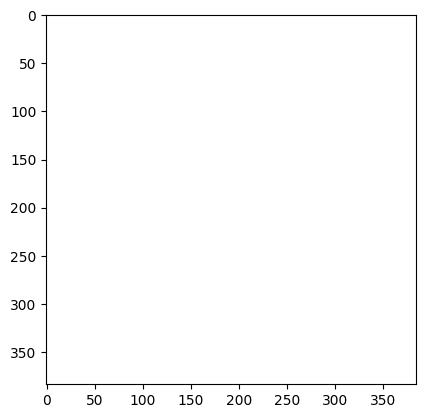

In [11]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid
print(mri.shape)
for i in range(mri.shape[2]):  # Sagital view
    plt.imshow(mri[:,:,i], cmap="bone")
    #masking labelled image where the channel is 0, to only visualize pixels corresponding to prostate
    #in labelled images
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation



In [12]:
HTML(animation.to_html5_video())  # convert the animation to a video for one slice

In [13]:
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data

def bicubic_interpolation_3d(volume, target_shape):
    """
    Apply 3D bicubic interpolation
    
    Args:
        volume (np.ndarray): Input 3D volume (H, W, D)
        target_shape (tuple): Desired output shape (H, W, D)
    Returns:
        np.ndarray: Interpolated volume
    """
    # Calculate zoom factors for each dimension
    
    zoom_factors = [t / s for t, s in zip(target_shape, volume.shape)]
    # print(zoom_factors)
    # Apply bicubic interpolation (order=3)
    return zoom(volume, zoom_factors, mode='nearest')

def process_volume(mri_data, label_data, target_shape=(512, 512, None)):
    """
    Process both image and label volumes
    """
    # Determine target depth (keep original if None)
    target_shape = list(target_shape)
    if target_shape[2] is None:
        target_shape[2] = mri_data.shape[2]
    
    # Interpolate MRI data
    interpolated_mri = bicubic_interpolation_3d(mri_data, target_shape)
    
    # For labels, use nearest neighbor interpolation (order=0) to preserve segmentation
    interpolated_label = zoom(label_data, 
                            [t / s for t, s in zip(target_shape, label_data.shape)],
                            order=0,
                            mode='nearest')
    
    return interpolated_mri, interpolated_label

In [14]:
@staticmethod
def extract_files(root):
    """
    Extract the paths to all slices given the root path (ends with train or val)
    Only selects files NOT ending with _segmentation.nii.gz
    """
    files = []
    for subject in root.glob("*.nii.gz"):
        # slice_path = subject/"data"
        # Add condition to exclude segmentation files
            if not str(subject).endswith('_segmentation.nii.gz'):
                files.append(subject)
    return files

all_files = extract_files(root)
len(all_files)

86

In [15]:
len(all_files)

86

In [16]:
# !rm -rf Vnet/final_data_multiclass/Preprocessed
# !rm -rf Vnet/final_data_multiclass/Preprocessed_test

In [18]:
#Processing test data as well
root_test = Path("guided_studies/final_data_multiclass/test/")
all_files_test =  extract_files(root_test)
len(all_files_test)

17

In [20]:
path = Path("Vnet/final_data_multiclass/Preprocessed_test/3")  # Select a subject

In [21]:
# Choose a file and load slice + mask

file = "3.npy" #since there are no slices the file name is same as folder name
image = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

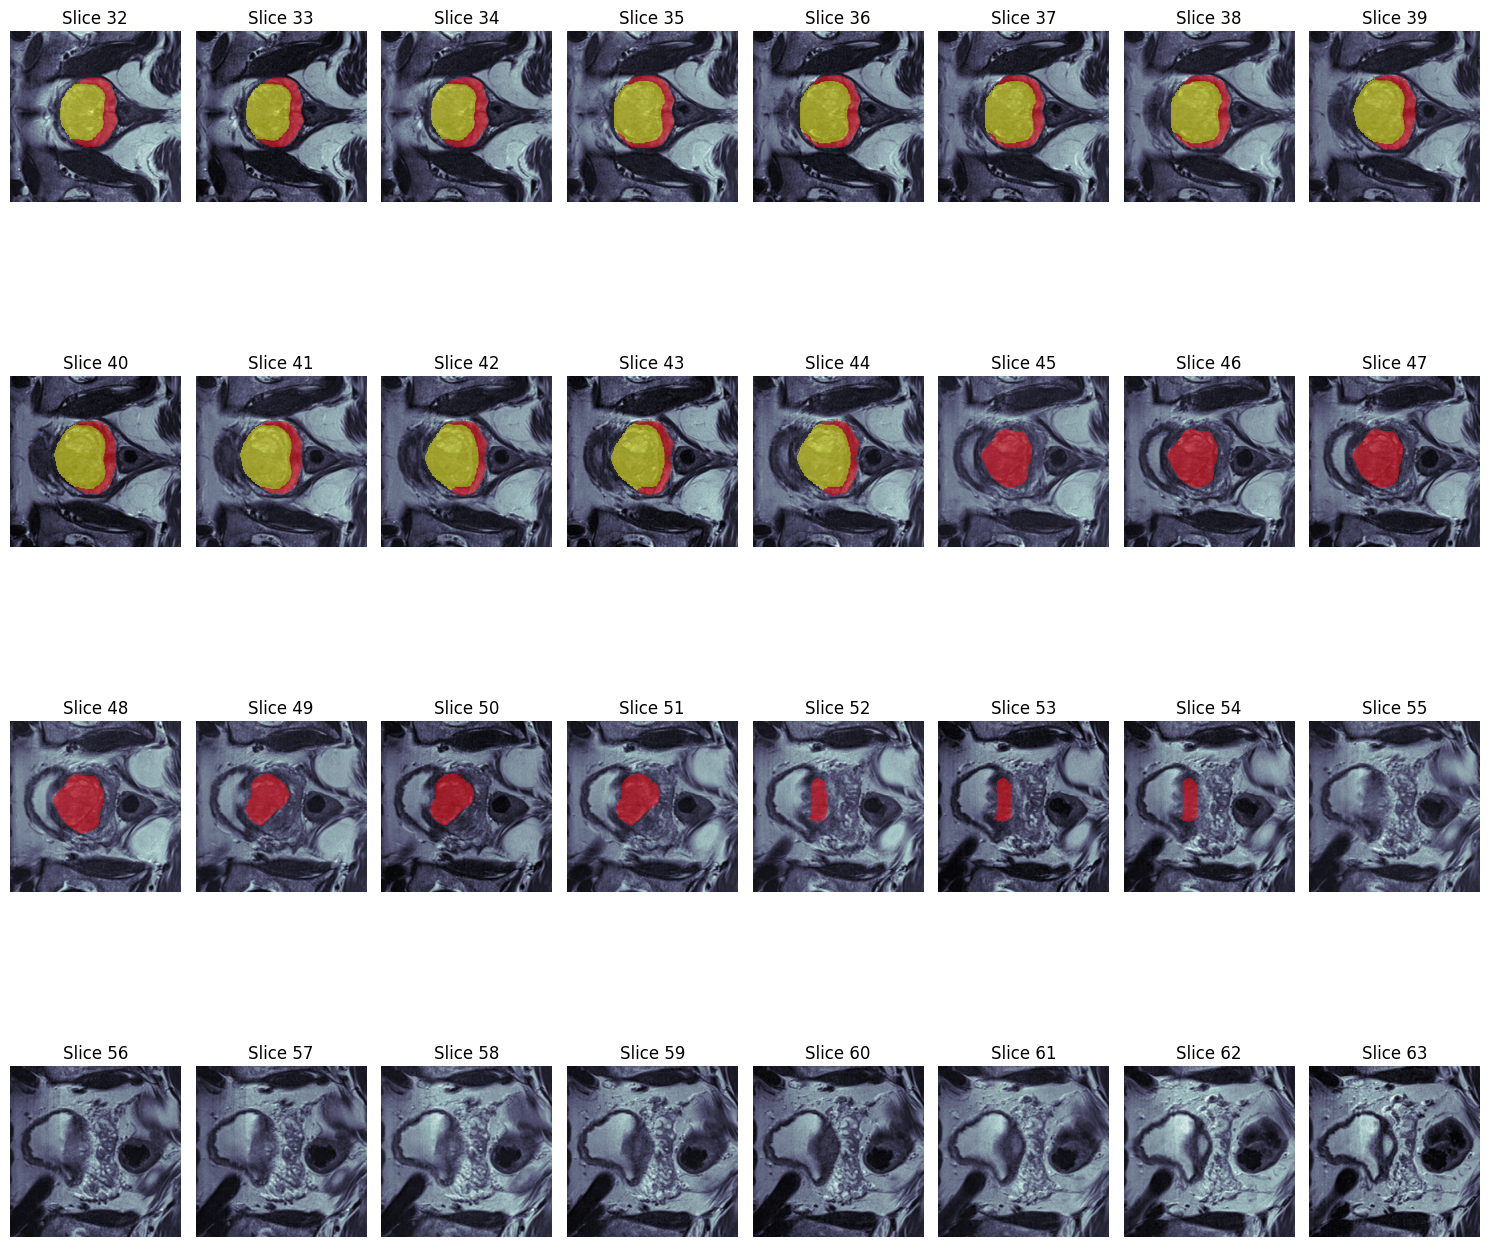

In [22]:
rows, cols = 4, 8  # Adjust based on the number of slices
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
j = 32
for i in range(rows * cols):
    # print(i)
    if i >= image.shape[2]:  # Stop if all slices are visualized
        break
    ax = axes[i // cols, i % cols]
    ax.imshow(image[:, :, j], cmap="bone")  # Display the slice
    masked = np.ma.masked_where(mask[:, :, j] == 0, mask[ :, :, j])
    ax.imshow(masked, alpha=0.5, cmap="autumn")  # Overlay the mask
    ax.set_title(f"Slice {j}")
    ax.axis("off")
    j = j+1

plt.tight_layout()
plt.show()

In [23]:
#Leave one site for testing and one site for validation using 4fold CV

In [24]:
import torch
import random
from torchvision import transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.transforms import functional as F


from PIL import Image

/ext3/miniforge3/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [25]:
import torch
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path
from monai.transforms import (
    Compose, RandRotate90, RandFlip, RandZoom, RandGaussianNoise, Rand3DElastic, EnsureType
)

class ProstateDataset(Dataset):
    def __init__(self, root, transform=None, train=True, num_classes=3):
        self.root = Path(root)
        self.transform = transform
        self.train = train
        self.num_classes = num_classes
        self.all_files = self.extract_files(self.root)
        
        # Define augmentations for training data
        if self.train:
            self.augmentations = Compose([
                EnsureType(),
                RandFlip(prob=0.5, spatial_axis=0),
                RandFlip(prob=0.5, spatial_axis=1),
                RandFlip(prob=0.5, spatial_axis=2),
                RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
                RandGaussianNoise(prob=0.3, mean=0, std=0.01),
                Rand3DElastic(prob=0.2, sigma_range=(4, 6), magnitude_range=(100, 200))
            ])
        else:
            self.augmentations = None


    @staticmethod
    def extract_files(root):
        """Find all volume files in the dataset structure"""
        files = []
        for subject in sorted(root.glob("*")):
            slice_path = subject/"data"
            if slice_path.exists():
                files.extend(list(slice_path.glob("*.npy")))
        return files

    @staticmethod
    def change_img_to_label_path(path):
        """Convert image path to corresponding mask path"""
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def create_one_hot_mask(self, mask):
        """Convert integer mask to one-hot encoded mask"""
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for i in range(self.num_classes):
            one_hot_mask[i] = (mask == i)
        return one_hot_mask

    def __getitem__(self, idx):
        volume_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(volume_path)
        
        if not mask_path.exists():
            raise FileNotFoundError(f"Mask not found at {mask_path}")
            
        try:
            # Load and preprocess data
            volume = np.load(volume_path).astype(np.float32)
            mask = np.load(mask_path).astype(np.int64)  # Keep as int64 for class labels
            
            # Add channel dimension
            if volume.ndim == 3:
                volume = volume[None, ...]
            if mask.ndim == 3:
                mask = mask[None, ...]  # Single channel with class indices
                
            # Convert to tensor
            volume = torch.from_numpy(volume).float()
            mask = torch.from_numpy(mask).long()  # Use long dtype for class indices

            combined = torch.cat((volume, mask), dim=0)
            # Apply augmentation if in training mode
            if self.train and self.augmentations:
              
                combined = self.augmentations(combined)
            
            # Split back into volume and mask
            volume = combined[:1]  # First channel is the volume
            mask = combined[1:]    # Remaining channels are the mask
                
                
            return volume, mask
            
        except Exception as e:
            print(f"Error loading files: {volume_path} or {mask_path}")
            raise e
            
    # one hot encoding operation
    # def __getitem__(self, idx):
    #     # Load volume and mask
    #     volume_path = self.all_files[idx]
    #     mask_path = self.change_img_to_label_path(volume_path)
        
    #     if not mask_path.exists():
    #         raise FileNotFoundError(f"Mask not found at {mask_path}")
            
    #     try:
    #         # Load and preprocess data
    #         volume = np.load(volume_path).astype(np.float32)
    #         mask = np.load(mask_path).astype(np.int64)  # Keep as int64 for class labels
            
    #         # Create one-hot encoded mask
    #         mask = self.create_one_hot_mask(mask)
            
    #         # Add channel dimension to volume if needed
    #         if volume.ndim == 3:
    #             volume = volume[None, ...]
                
    #         # Convert to tensor
    #         volume = torch.from_numpy(volume).float()
    #         mask = torch.from_numpy(mask).float()
            
    #         # Combine volume and mask for transformation
    #         combined = torch.cat((volume, mask), dim=0)
            
    #         # Apply augmentation if in training mode
    #         if self.train and self.augmentations:
    #             combined = self.augmentations(combined)
            
    #         # Split back into volume and mask
    #         volume = combined[:1]  # First channel is the volume
    #         mask = combined[1:]    # Remaining channels are the mask
                
    #         return volume, mask
            
    #     except Exception as e:
    #         print(f"Error loading files: {volume_path} or {mask_path}")
    #         raise e

    def __len__(self):
        """Return total number of volumes"""
        return len(self.all_files)

2025-01-07 14:09:49.917652: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 14:09:50.881403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736276991.146931  838593 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736276991.166363  838593 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 14:09:51.661214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [27]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import Image
import scipy.ndimage as ndi
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

class ElasticTransform:
    ''' Sigma and Alpha value set as per paper 
     Aldoj, N., Biavati, F., Michallek, F. et al. Automatic prostate and prostate zones segmentation 
     of magnetic resonance images using DenseNet-like U-net.
    '''
    def __init__(self, alpha= 512, sigma=21, alpha_affine=None):
        self.alpha = alpha  # Controls deformation intensity
        self.sigma = sigma  # Controls deformation smoothness
        self.alpha_affine = alpha_affine  # Controls affine deformation scale
        
    def __call__(self, img):
        # Convert PIL image to numpy array
        img_array = np.array(img)
        original_dtype = img_array.dtype
        img_array = img_array.astype(np.float32)
        
        # Get image dimensions
        shape = img_array.shape
        shape_size = shape[:2]
        
        # Calculate affine deformation scale if not provided
        if self.alpha_affine is None:
            self.alpha_affine = shape_size[0] * 0.08
        
        # Generate affine transformation
        center_square = np.float32(shape_size) // 2
        square_size = min(shape_size) // 3
        pts1 = np.float32([
            center_square + square_size,
            [center_square[0]+square_size, center_square[1]-square_size],
            center_square - square_size
        ])
        pts2 = pts1 + np.random.uniform(
            -self.alpha_affine,
            self.alpha_affine,
            size=pts1.shape
        ).astype(np.float32)
        
        # Apply affine transformation
        M = cv2.getAffineTransform(pts1, pts2)
        img_array = cv2.warpAffine(
            img_array,
            M,
            shape_size[::-1],
            borderMode=cv2.BORDER_REFLECT_101
        )
        
        # Generate displacement fields
        dx = gaussian_filter(
            (np.random.rand(*shape_size) * 2 - 1),
            self.sigma
        ) * self.alpha
        dy = gaussian_filter(
            (np.random.rand(*shape_size) * 2 - 1),
            self.sigma
        ) * self.alpha
        
        # Generate mesh grid and apply deformation
        x, y = np.meshgrid(
            np.arange(shape_size[1]),
            np.arange(shape_size[0])
        )
        
        indices = [
            np.reshape(y + dy, (-1, 1)),
            np.reshape(x + dx, (-1, 1))
        ]
        
        # Apply elastic deformation
        transformed_array = map_coordinates(
            img_array,
            indices,
            order=1,
            mode='reflect'
        ).reshape(shape_size)
        
        # Return to original dtype and convert back to PIL
        transformed_array = transformed_array.astype(original_dtype)
        return Image.fromarray(transformed_array)

# Validation Transform
val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

#all images are already normalized and standardized
image_transform = transforms.Compose([
    # ElasticTransform(alpha= 512, sigma=21, alpha_affine = None),
    # transforms.RandomAffine(degrees=15, scale=(1.55, 2.25)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)),
])

mask_transform = transforms.Compose([ 
    # ElasticTransform(alpha= 512, sigma=21, alpha_affine = None),
    # transforms.RandomAffine(degrees=15, scale=(1.55, 2.25)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.Resize((256,256)),
    # transforms.ToTensor()
    # For masks, ToTensor() scales to [0, 1]
])

mask_val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    # transforms.ToTensor()
])


/state/partition1/job-55641154/ipykernel_838593/1254335858.py:11: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates
/state/partition1/job-55641154/ipykernel_838593/1254335858.py:12: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [28]:
path = Path("Vnet/Preprocessed/train/")
# !pip install monai

In [29]:
import matplotlib.pyplot as plt

def visualize_augmentations(dataset, idx=0):
    """Visualize original vs augmented slices for 3D MRI segmentation."""
    original_volume, original_mask = dataset[idx]  # Get original sample
    augmented_volume, augmented_mask = dataset[idx]  # Get augmented sample (random)

    slice_idx = original_volume.shape[-1] // 2  # Select middle slice

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Original MRI Slice
    axes[0, 0].imshow(original_volume[0, :, :, slice_idx], cmap="bone")
    axes[0, 0].set_title("Original MRI")
    axes[0, 0].axis("off")

    # Original Mask
    axes[0, 1].imshow(original_volume[0, :, :, slice_idx], cmap="bone")
    axes[0, 1].imshow(original_mask[0, :, :, slice_idx], alpha=0.3, cmap="autumn")
    axes[0, 1].set_title("Original Mask")
    axes[0, 1].axis("off")

    # Augmented MRI Slice
    axes[1, 0].imshow(augmented_volume[0, :, :, slice_idx], cmap="bone")
    axes[1, 0].set_title("Augmented MRI")
    axes[1, 0].axis("off")

    # Augmented Mask
    axes[1, 1].imshow(augmented_volume[0, :, :, slice_idx], cmap="bone")
    axes[1, 1].imshow(augmented_mask[0, :, :, slice_idx], alpha=0.3, cmap="winter")
    axes[1, 1].set_title("Augmented Mask")
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

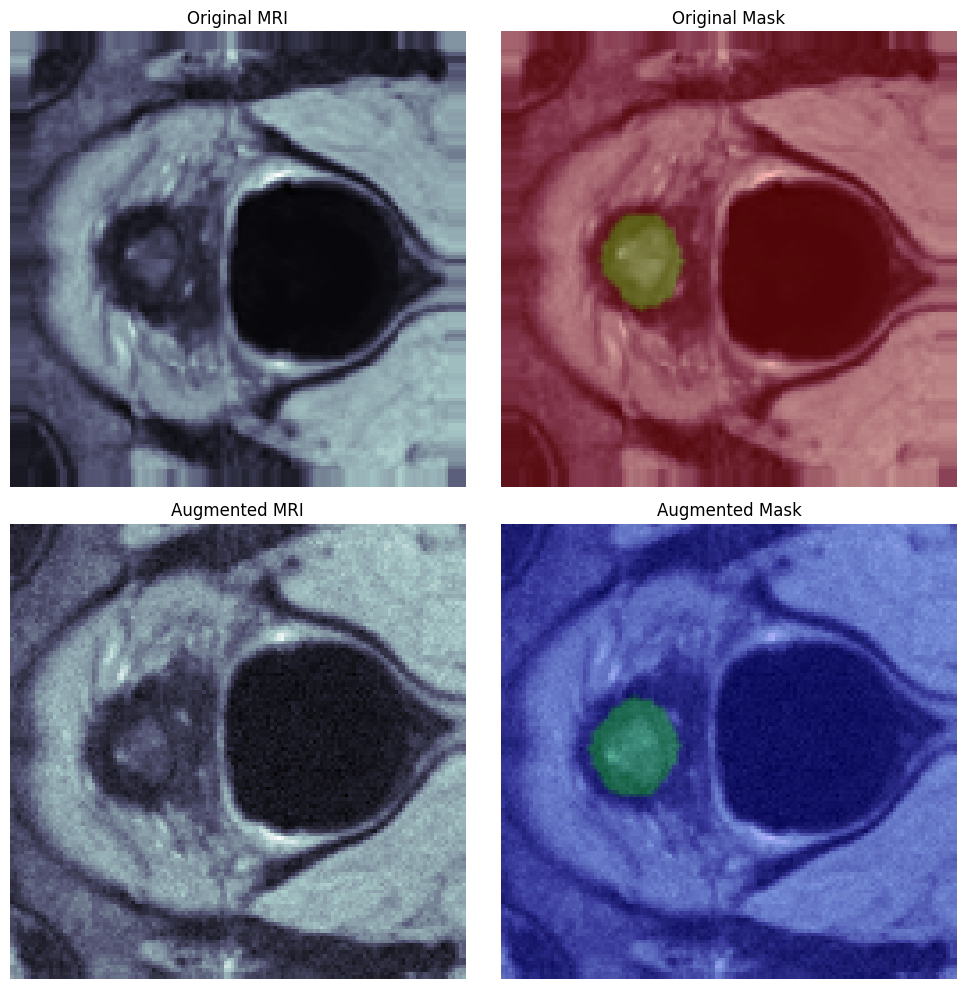

In [30]:
# Initialize dataset with augmentations
dataset = ProstateDataset(root=path, train=True)

# Visualize augmentations
visualize_augmentations(dataset, idx=5) 

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class InputTransition(nn.Module):
    def __init__(self, out_channels, is_3d=True):
        super(InputTransition, self).__init__()
        self.conv1 = nn.Conv3d(1, out_channels, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(out_channels)
        self.relu1 = ELUCons(is_3d, out_channels)

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        # Split the number of channels
        x16 = torch.cat((x, x, x, x, x, x, x, x,
                         x, x, x, x, x, x, x, x), 1)
        out = self.relu1(torch.add(out, x16))
        return out

class OutputTransition(nn.Module):
    """
    Final transition: Converts features to segmentation output.
    Modified for multiclass segmentation.
    """
    def __init__(self, in_chans, num_classes):
        super(OutputTransition, self).__init__()
        self.conv1 = nn.Conv3d(in_chans, num_classes, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(num_classes)
        self.relu1 = ELUCons(True, num_classes)

    def forward(self, x):
        # Apply convolution and batch normalization
        out = self.relu1(self.bn1(self.conv1(x)))
        return out  # Return raw logits (no activation function)


class VNet(nn.Module):
    """
    Complete VNet architecture for multiclass segmentation.
    Modifications:
    - Removed sigmoid activation for compatibility with CrossEntropyLoss.
    - Flexible number of input/output channels.
    """
    def __init__(self, in_channels=1, num_classes=3):  # Set num_classes to match your dataset
        super(VNet, self).__init__()
        self.in_tr = InputTransition(16, True)
        self.down_tr32 = DownTransition(16, 1, True)
        self.down_tr64 = DownTransition(32, 2, True)
        self.down_tr128 = DownTransition(64, 3, True, dropout=True)
        self.down_tr256 = DownTransition(128, 2, True, dropout=True)
        self.up_tr256 = UpTransition(256, 256, 2, True, dropout=True)
        self.up_tr128 = UpTransition(256, 128, 2, True, dropout=True)
        self.up_tr64 = UpTransition(128, 64, 1, True)
        self.up_tr32 = UpTransition(64, 32, 1, True)
        self.out_tr = OutputTransition(32, num_classes)  # Output raw logits

    def forward(self, x):
        out16 = self.in_tr(x)
        out32 = self.down_tr32(out16)
        out64 = self.down_tr64(out32)
        out128 = self.down_tr128(out64)
        out256 = self.down_tr256(out128)
        out = self.up_tr256(out256, out128)
        out = self.up_tr128(out, out64)
        out = self.up_tr64(out, out32)
        out = self.up_tr32(out, out16)
        out = self.out_tr(out)  # Output raw logits
        return out

class ContBatchNorm3d(nn.Module):
    def __init__(self, num_features):
        super(ContBatchNorm3d, self).__init__()
        self.bn = nn.BatchNorm3d(num_features)
        
    def forward(self, x):
        return self.bn(x)

class ELUCons(nn.Module):
    def __init__(self, is_3d, nchan):
        super(ELUCons, self).__init__()
        self.elu = nn.ELU(inplace=True)

    def forward(self, x):
        return self.elu(x)
class DownTransition(nn.Module):
    def __init__(self, in_channels, n_convs, is_3d=True, dropout=False):
        super(DownTransition, self).__init__()
        out_channels = 2 * in_channels
        self.down_conv = nn.Conv3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.bn1 = ContBatchNorm3d(out_channels)
        self.do1 = passthrough
        self.relu1 = ELUCons(is_3d, out_channels)
        self.relu2 = ELUCons(is_3d, out_channels)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(out_channels, n_convs, is_3d)

    def forward(self, x):
        down = self.relu1(self.bn1(self.down_conv(x)))
        out = self.do1(down)
        out = self.ops(out)
        out = self.relu2(torch.add(out, down))
        return out

def _make_nConv(in_channels, n_convs, is_3d=True):
    layers = []
    for _ in range(n_convs):
        layers.append(ConvEluBlock(in_channels, in_channels, is_3d))
    return nn.Sequential(*layers)

class ConvEluBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_3d=True):
        super(ConvEluBlock, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=5, padding=2)
        self.bn = ContBatchNorm3d(out_channels)
        self.relu = ELUCons(is_3d, out_channels)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

def passthrough(x, **kwargs):
    return x
class UpTransition(nn.Module):
    def __init__(self, in_channels, out_channels, n_convs, is_3d=True, dropout=False):
        super(UpTransition, self).__init__()
        self.up_conv = nn.ConvTranspose3d(in_channels, out_channels // 2, kernel_size=2, stride=2)
        self.bn1 = ContBatchNorm3d(out_channels // 2)
        self.do1 = passthrough
        self.do2 = nn.Dropout3d() if dropout else passthrough
        self.relu1 = ELUCons(is_3d, out_channels // 2)
        self.relu2 = ELUCons(is_3d, out_channels)
        self.ops = _make_nConv(out_channels, n_convs, is_3d)

    def forward(self, x, skipx):
        out = self.do1(x)
        skipxdo = self.do2(skipx)
        out = self.relu1(self.bn1(self.up_conv(out)))
        xcat = torch.cat((out, skipxdo), 1)
        out = self.ops(xcat)
        out = self.relu2(torch.add(out, xcat))
        return out


In [32]:
num_classes = 3  # Adjust based on your dataset
model = VNet(in_channels=1, num_classes=num_classes)

In [33]:
# random_input = torch.randn(1, 1, 256, 256)
# output = model(random_input)
# print(output.shape)
# assert output.shape == torch.Size([1, 3, 256, 256])

In [34]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [35]:
from pathlib import Path
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
#import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
import datetime

batch_size = 8
now = str(datetime.datetime.now())
#CHANGE LOG NAME LATER PLEASE
wandb_logger = WandbLogger(project='prostatemrisegmentation',name='Vnet_multiseg'+now,resume="allow")

In [36]:
# Create the dataset objects
train_path = Path("Vnet/final_data_multiclass/Preprocessed/train/")
val_path = Path("Vnet/final_data_multiclass/Preprocessed/val/")
test_path = Path("Vnet/final_data_multiclass/Preprocessed_test/")

train_dataset =ProstateDataset(root=train_path, train=True)
val_dataset = ProstateDataset(root=val_path, train=False)
test_dataset = ProstateDataset(test_path, train=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images and {len(test_dataset)} test images")

There are 69 train images and 17 val images and 17 test images


In [37]:
batch_size = 2
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.5, smooth=1e-5, class_weights=None):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth
        self.class_weights = class_weights

    def _validate_shapes(self, preds, targets):
        """
        Validates input shapes and provides detailed error messages.
        Returns processed tensors ready for loss calculation.
        """
        # Check basic requirements
        if not torch.is_floating_point(preds):
            raise ValueError("Predictions must be floating point tensors")
            
        # Print shapes for debugging
        print(f"Initial shapes - Preds: {preds.shape}, Targets: {targets.shape}")
        
        # Handle categorical targets
        if targets.ndim == preds.ndim - 1:
            print("Converting categorical targets to one-hot encoding")
            targets = F.one_hot(targets.long(), num_classes=preds.shape[1])
            # Move class dimension to match predictions
            targets = targets.permute(0, -1, *range(1, targets.ndim-1))
            print(f"After one-hot conversion - Targets shape: {targets.shape}")
        
        # Ensure shapes match exactly
        if preds.shape != targets.shape:
            raise ValueError(f"Shape mismatch after processing: preds={preds.shape}, targets={targets.shape}")
            
        # Verify both tensors are on same device
        if preds.device != targets.device:
            raise ValueError(f"Device mismatch: preds on {preds.device}, targets on {targets.device}")
            
        return preds, targets

    def _compute_class_scores(self, class_pred, class_target):
        """
        Computes TP, FP, FN for a single class with careful shape handling.
        Returns scores after appropriate dimension reduction.
        """
        # Ensure binary values for target
        class_target = class_target.bool().float()
        
        # Get the spatial dimensions dynamically
        spatial_dims = tuple(range(1, class_pred.ndim))
        print(f"Computing scores over spatial dimensions: {spatial_dims}")
        
        # Calculate intersection (TP) and union terms
        TP = (class_pred * class_target).sum(dim=spatial_dims)
        FP = (class_pred * (1 - class_target)).sum(dim=spatial_dims)
        FN = ((1 - class_pred) * class_target).sum(dim=spatial_dims)
        
        # Verify shapes after reduction
        assert TP.ndim == 1, f"TP should be 1D (batch), got shape {TP.shape}"
        assert FP.shape == TP.shape, f"FP shape {FP.shape} doesn't match TP shape {TP.shape}"
        assert FN.shape == TP.shape, f"FN shape {FN.shape} doesn't match TP shape {TP.shape}"
        
        return TP, FP, FN

    def forward(self, preds, targets):
        # First apply softmax to predictions
        preds = F.softmax(preds, dim=1)
        
        # Validate and prepare input tensors
        preds, targets = self._validate_shapes(preds, targets)
        
        losses = []
        num_classes = preds.shape[1]
        
        # Process each class
        for class_idx in range(num_classes):
            # Extract class-specific predictions and targets
            class_pred = preds[:, class_idx, ...]
            class_target = targets[:, class_idx, ...]
            
            print(f"Processing class {class_idx}")
            print(f"Class shapes - Pred: {class_pred.shape}, Target: {class_target.shape}")
            
            # Compute class scores
            TP, FP, FN = self._compute_class_scores(class_pred, class_target)
            
            # Calculate Tversky index for this class
            numerator = TP + self.smooth
            denominator = TP + (self.alpha * FP) + (self.beta * FN) + self.smooth
            
            # Ensure no division by zero
            tversky = torch.where(
                denominator > 0,
                numerator / denominator,
                torch.ones_like(numerator)
            )
            
            # Apply focal weighting
            focal_tversky = (1 - tversky) ** self.gamma
            
            # Apply class weights if provided
            if self.class_weights is not None:
                class_weight = self.class_weights[class_idx]
                focal_tversky = focal_tversky * class_weight
                
            losses.append(focal_tversky)
        
        # Combine losses across classes and batch
        stacked_losses = torch.stack(losses, dim=0)  # [num_classes, batch_size]
        mean_loss = torch.mean(stacked_losses)  # Mean across classes and batch
        
        # Final shape verification
        assert not torch.isnan(mean_loss), "NaN detected in final loss"
        assert mean_loss.ndim == 0, "Final loss should be a scalar"
        
        return mean_loss

    @staticmethod
    def calculate_class_weights(dataset, num_classes):
        """
        Calculates balanced class weights from the dataset.
        """
        class_counts = torch.zeros(num_classes)
        total_samples = 0
        
        for _, target in dataset:
            # Handle both categorical and one-hot targets
            if target.ndim > len(target.shape[:-1]):  # One-hot encoded
                target = torch.argmax(target, dim=1)
                
            unique_classes, counts = torch.unique(target, return_counts=True)
            for class_idx, count in zip(unique_classes, counts):
                class_counts[class_idx] += count
                total_samples += count
        
        # Calculate balanced weights
        class_weights = total_samples / (num_classes * class_counts + 1e-5)
        
        # Normalize weights
        class_weights = class_weights / torch.sum(class_weights)
        
        print("Class weights calculated:", class_weights)
        return class_weights

In [39]:
class CombinedSegmentationLoss(nn.Module):
    def __init__(self, num_classes=3, ft_weight=0.5, ce_weight=0.5):
        """
        Combined loss function using both Focal Tversky and Cross Entropy losses.
        
        Args:
            num_classes: Number of segmentation classes (default 3 for background, prostate, central)
            ft_weight: Weight for Focal Tversky Loss contribution (default 0.5)
            ce_weight: Weight for Cross Entropy Loss contribution (default 0.5)
        """
        super().__init__()
        
        # Initialize both loss functions
        self.focal_tversky = FocalTverskyLoss()
        
        # Create class weights that give more importance to prostate and central gland
        class_weights = torch.tensor([0.1, 0.45, 0.45])
        self.cross_entropy = nn.CrossEntropyLoss(weight=class_weights)
        
        # Weights for combining the losses
        self.ft_weight = ft_weight
        self.ce_weight = ce_weight
        
    def forward(self, predictions, targets):
        """
        Compute the combined loss.
        
        Args:
            predictions: Model predictions [batch_size, num_classes, H, W]
            targets: Ground truth labels [batch_size, num_classes, H, W]
            
        Returns:
            Combined weighted loss
        """
        # Compute Focal Tversky Loss
        ft_loss = self.focal_tversky(predictions, targets)
        
        # For Cross Entropy, we need class indices rather than one-hot
        targets_indices = targets.argmax(dim=1)
        ce_loss = self.cross_entropy(predictions, targets_indices)
        
        # Combine losses with their respective weights
        combined_loss = (self.ft_weight * ft_loss) + (self.ce_weight * ce_loss)
        
        # For debugging, let's track individual losses
        return combined_loss

In [40]:
import torch
import torch.amp as amp

import torch
import torch.nn as nn


def DiceLoss(probs, labels, num_classes=3):
    """
    Soft Dice loss for binary segmentation.
    """
    # sigmoid = torch.nn.Sigmoid()
    # probs = sigmoid(probs)
    probs = probs.view(probs.shape[0], -1).float()# Flatten predictions
    labels = labels.view(labels.shape[0], -1).float() # Flatten labels
    
    print(f'Probs shape, {probs.shape}')
    print(f'Labels shape, {labels.shape}')
   
        # Compute Dice numerator and denominator
    numer = torch.sum(probs * labels,dim=1)  # Intersection
    denor = torch.sum(probs + labels,dim=1)  # Union

        # Compute Dice coefficient
    dice = (2 * numer + 1e-8) / (denor + 1e-8)
    dice_loss = 1. - dice  # Return Dice loss
    print(f"Auto dice (Batch): {dice_loss.mean()}")
    return dice_loss.mean()


In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [42]:
# Rerun this test by removing site F and keeping Site E for test
# Run this for Cross Entropy and Focal Tversky loss
# *****Fo guided studies******
# Unet with attention and Vnet

In [43]:
TF_ENABLE_ONEDNN_OPTS=0

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pytorch_lightning as pl
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb

class ProstateSegmentation(pl.LightningModule):
    def __init__(self, num_classes=3, learning_rate=1e-4):
        super().__init__()
        self.model = VNet(in_channels=1, num_classes=num_classes)
        
        # Modified loss function with adjusted weights for class imbalance
        self.loss_function = DiceCELoss(
            softmax=True,
            to_onehot_y=True,
            lambda_ce=0.7,    # Increased CE weight
            lambda_dice=0.3,  # Reduced Dice weight
            include_background=False
        )
        
        # Modified Dice metric configuration
        self.dice_metric = DiceMetric(
            include_background=False,
            reduction="mean",
            get_not_nans=False
        )
        
        self.post_pred = torch.nn.Softmax(dim=1)
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        
        # Add input validation and normalization
        if mri.abs().max() > 1:
            mri = mri / mri.abs().max()
        
        # Get predictions
        logits = self(mri)
        
        # Print class distribution for monitoring
        pred_classes = torch.argmax(self.post_pred(logits), dim=1)
        target_dist = torch.unique(mask, return_counts=True)
        pred_dist = torch.unique(pred_classes, return_counts=True)
        
        self.log("class_dist/target", dict(zip(target_dist[0].cpu().numpy(), 
                                             target_dist[1].cpu().numpy())))
        self.log("class_dist/pred", dict(zip(pred_dist[0].cpu().numpy(), 
                                           pred_dist[1].cpu().numpy())))
        
        # Compute loss
        train_loss = self.loss_function(logits, mask)
        self.log("train_loss", train_loss, prog_bar=True, sync_dist=True)
        
        return train_loss

    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        
        # Normalize input
        if mri.abs().max() > 1:
            mri = mri / mri.abs().max()
            
        # Get predictions
        logits = self(mri)
        probs = self.post_pred(logits)
        
        # Compute per-class Dice scores
        for class_idx in range(1, self.num_classes):
            pred_class = (torch.argmax(probs, dim=1) == class_idx)
            true_class = (mask.squeeze(1) == class_idx)
            
            intersection = (pred_class & true_class).sum().float()
            union = pred_class.sum() + true_class.sum()
            
            dice = (2. * intersection) / (union + 1e-8)
            self.log(f"val_dice/class_{class_idx}", dice.item(), prog_bar=True)
        
        # Compute loss
        val_loss = self.loss_function(logits, mask)
        self.log("val_loss", val_loss, prog_bar=True, sync_dist=True)
        
        # Compute overall dice metric
        self.dice_metric(y_pred=probs, y=mask)
        
        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-4
        )
        
        scheduler = {
                optimizer,
                mode='min',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

    def log_images(self, mri, pred, mask, name):
        pred = torch.argmax(pred, dim=0).float()
    
        class_colors = np.array([
            [0, 0, 0],      # Background - black
            [1, 0, 0],      # Prostate - red
            [0, 1, 0]       # Central Gland - green
        ])
        
        # Function to create a subplot for a given slice
        def plot_slice(ax, data, title):
            if data.ndim == 4:  # RGB data with shape (H, W, D, 3)
                # Select middle slice and keep RGB channels
                middle_slice = data.shape[2] // 2
                data = data[:, :, middle_slice, :]
            elif data.ndim == 3:  # Grayscale data with shape (H, W, D)
                middle_slice = data.shape[2] // 2
                data = data[:, :, middle_slice]
            
            if data.shape[-1] == 3:  # RGB image
                ax.imshow(data)
            else:  # Grayscale image
                ax.imshow(data, cmap='bone')
            ax.set_title(title)
            ax.axis('off')
    
        # Create a figure with 3 rows (one for each axis) and 3 columns
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        
        for i, axis in enumerate(['Sagittal', 'Coronal', 'Axial']):
            # Select middle slice for each axis
            if i == 0:  # Sagittal view
                slice_mri = mri[mri.shape[0]//2, :, :].cpu().numpy()
                slice_mask = mask[mask.shape[0]//2, :, :].cpu().numpy()
                slice_pred = pred[pred.shape[0]//2, :, :].cpu().numpy()
            elif i == 1:  # Coronal view
                slice_mri = mri[:, mri.shape[1]//2, :].cpu().numpy()
                slice_mask = mask[:, mask.shape[1]//2, :].cpu().numpy()
                slice_pred = pred[:, pred.shape[1]//2, :].cpu().numpy()
            else:  # Axial view
                slice_mri = mri[:, :, mri.shape[2]//2].cpu().numpy()
                slice_mask = mask[:, :, mask.shape[2]//2].cpu().numpy()
                slice_pred = pred[:, :, pred.shape[2]//2].cpu().numpy()
            
            # Plot MRI slice
            plot_slice(axes[i, 0], slice_mri, f'{axis} MRI')
            
            # Convert indices to RGB colors for mask and prediction
            colored_mask = class_colors[slice_mask.astype(int)]
            colored_pred = class_colors[slice_pred.astype(int)]
            
            # Plot Ground Truth and Prediction
            plot_slice(axes[i, 1], colored_mask, f'{axis} Ground Truth')
            plot_slice(axes[i, 2], colored_pred, f'{axis} Prediction')
    
        fig.suptitle(f"{name}: Ground Truth vs Prediction", y=0.98)
        plt.tight_layout()
    
        wandb_image = wandb.Image(fig)
        self.logger.experiment.log({f'image_{name}': wandb_image})
        plt.close(fig)
    

In [45]:
# Instanciate the model and set the random seed
torch.manual_seed(0)
model = ProstateSegmentation(num_classes=3, learning_rate=1e-4)

In [46]:
# Create the checkpoint callback
checkpoint_callback_val = ModelCheckpoint(
        monitor='Val Loss',
        every_n_epochs=10,
        save_top_k=10,
        save_last=True,
        mode='min',
        dirpath = './guided_studies/ood/mri_image_segmentations/val/Vnet_multiclasAttsexperiment_'+now)

checkpoint_callback_train = ModelCheckpoint(
        monitor='Train Loss',
        every_n_epochs=10,
        save_top_k=10,
        save_last=True,
        mode='min',
        dirpath = './guided_studies/ood/mri_image_segmentations/train/Vnet_multiclassAttexperiment_'+now)

In [47]:
torch.cuda.is_available()

True

In [48]:
# Specify the number of GPUs. Use 'cpu' for CPU training, 'gpu' for GPU training
gpus = 1  # You can change this to 0 for CPU, or increase for multiple GPUs

# Create the trainer
trainer = pl.Trainer(
    gradient_clip_val=1.0,
    gradient_clip_algorithm='norm',
    accelerator="gpu" if gpus > 0 else "cpu",  # Use "gpu" if gpus is greater than 0, otherwise "cpu"
    devices=gpus if gpus > 0 else None,       # Specify the number of devices (GPUs) or None for CPU
    logger=wandb_logger,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback_val,checkpoint_callback_train],          # Wrap the callback in a list
    max_epochs=60#change step size of optimizer accordingly
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [49]:
# # #Load from a checkpoint if training is complete
model = ProstateSegmentation.load_from_checkpoint("guided_studies/ood/mri_image_segmentations/val/Vnet_multiclasAttsexperiment_2025-01-06 02:55:51.212856/last-v1.ckpt")


# !nvidia-smi
# !kill  3781166


In [50]:
#   # Uncomment when running for first time 
# trainer.fit(model, train_loader, val_loader)

# # 

In [51]:

#If Training was successful
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [52]:
  # Uncomment when running for first time 
wandb.finish()
plt.close()

In [53]:
import torch
# from ND_Crossentropy import CrossentropyND, TopKLoss, WeightedCrossEntropyLoss
from torch import nn
from torch.autograd import Variable
from torch import einsum
import numpy as np

class GDiceLossV2(nn.Module):
    def __init__(self, apply_nonlin=None, smooth=1e-5):
        """
        Generalized Dice;
        Copy from: https://github.com/wolny/pytorch-3dunet/blob/6e5a24b6438f8c631289c10638a17dea14d42051/unet3d/losses.py#L75
        paper: https://arxiv.org/pdf/1707.03237.pdf
        tf code: https://github.com/NifTK/NiftyNet/blob/dev/niftynet/layer/loss_segmentation.py#L279
        """
        super(GDiceLossV2, self).__init__()

        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, net_output, gt):
        shp_x = net_output.shape # (batch size,class_num,x,y,z)
        shp_y = gt.shape # (batch size,1,x,y,z)
        # one hot code for gt
        with torch.no_grad():
            if len(shp_x) != len(shp_y):
                gt = gt.view((shp_y[0], 1, *shp_y[1:]))

            if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
                # if this is the case then gt is probably already a one hot encoding
                y_onehot = gt
            else:
                gt = gt.long()
                y_onehot = torch.zeros(shp_x)
                if net_output.device.type == "cuda":
                    y_onehot = y_onehot.cuda(net_output.device.index)
                y_onehot.scatter_(1, gt, 1)


        if self.apply_nonlin is not None:
            net_output = self.apply_nonlin(net_output)

        input = flatten(net_output)
        target = flatten(y_onehot)
        target = target.float()
        target_sum = target.sum(-1)
        class_weights = Variable(1. / (target_sum * target_sum).clamp(min=self.smooth), requires_grad=False)

        intersect = (input * target).sum(-1) * class_weights
        intersect = intersect.sum()

        denominator = ((input + target).sum(-1) * class_weights).sum()
        dice_score = - 2. * intersect / denominator.clamp(min=self.smooth)
        return 1.+dice_score  

In [54]:
loss_fn = GDiceLossV2()

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order).contiguous()
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)

In [55]:
def DiceLoss(pred, target, smooth=1e-5):
    pred = F.softmax(pred, dim=1)
    # Calculate dice per class
    dice_scores = []
    for class_idx in range(1, pred.shape[1]):  # Skip background
        print("Pred ",pred.shape)
        pred_class = (pred[:, class_idx] > 0.5).float()
        target_class = (target == class_idx).float()
        intersection = (pred_class * target_class).sum()
        dice = (2. * intersection + smooth) / (pred_class.sum() + target_class.sum() + smooth)
        dice_scores.append(dice)
    return 1.-torch.stack(dice_scores).mean()

In [56]:

def calculateDiceScore(data_loader, model, device, num_classes=3):
    model.eval()
    dice_scores = torch.zeros(num_classes - 1).to(device)  # Move to correct device
    count = torch.zeros(num_classes - 1).to(device)

    with torch.no_grad():
        for batch in data_loader:
            images, masks = batch
            # Move batch to device
            images = images.to(device)
            masks = masks.to(device)

            # Get predictions
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            # Calculate Dice score for each class
            for class_idx in range(1, num_classes):
                pred_class = (predictions == class_idx)
                mask_class = (masks.squeeze(1) == class_idx)

                intersection = (pred_class & mask_class).sum().float()
                union = pred_class.sum() + mask_class.sum()

                if union > 0:
                    dice_scores[class_idx - 1] += (2 * intersection) / (union + 1e-8)
                    count[class_idx - 1] += 1

    # Average Dice scores
    mean_dice_per_class = dice_scores / count
    mean_dice_overall = mean_dice_per_class.mean()

    return 1.-mean_dice_overall.item(), mean_dice_per_class.tolist()

# Usage:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Ensure model is on correct device

dice_score_train = calculateDiceScore(train_loader, model, device)
dice_score_val = calculateDiceScore(val_loader, model, device)
dice_score_test = calculateDiceScore(test_loader, model, device)

In [57]:
# !nvidia-smi
# !kill 1840458

In [58]:
# dice_score_train = calculateDiceScore(train_loader)
# dice_score_val = calculateDiceScore(val_loader)
# dice_score_test = calculateDiceScore(test_loader)


dice_scores = [{
}]
df = pd.DataFrame(dice_scores)

# #this is the score for one validation

In [59]:
print(df)

   Train Dice Score  Validation Dice Score  Test Dice Score
0           0.87003               0.806808         0.864498


In [186]:
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D 
def visualizeResults3D(dataset, sample_idx, slice_idx=None, type=None):
    # Load data
    volume, label = dataset[sample_idx]
    volume = torch.tensor(volume).to(device).unsqueeze(0)
    
    if slice_idx is None:
        slice_idx = volume.shape[-1] // 2
    
    # Model prediction
    with torch.no_grad():
        pred = model(volume)
        print(pred.shape)

        pred = torch.softmax(pred, dim=1)
        pred = pred.cpu().squeeze().numpy()
        print(np.unique(label))
        print(pred.shape)
        pred = np.argmax(pred, axis=0)
        print("After argmax ",pred.shape)

        pred = pred[ :, :, slice_idx].astype(np.float32)

    # Prepare MRI slice and ground truth
    mri_slice = volume.cpu().squeeze().numpy()[:, :, slice_idx]
    label = label.squeeze()
    if len(label.shape) == 4:
        label = label[:, :, :, slice_idx]
    else:
        label = label[:, :, slice_idx]

    # Visualization parameters
    num_classes = 3
    gt_colors = ['none', 'autumn', 'winter']
    pred_colors = ['none', 'cool', 'pink']
    class_names = ['Background', 'Prostate', 'Central Zone']
    
    # Create figure with five subplots
    fig, axes = plt.subplots(1, 4, figsize=(25, 5))
    
    # 1. MRI Slice
    axes[0].imshow(mri_slice, cmap="gray")
    axes[0].set_title("MRI Slice")
    axes[0].axis("off")

    # 2. Ground Truth Only
    axes[1].imshow(mri_slice, cmap="gray")
    for cls in range(1, num_classes):
        if len(label.shape) == 3:
            gt_mask = np.ma.masked_where(label[cls] != cls, label[cls])
        else:
            gt_mask = np.ma.masked_where(label != cls, label)
        axes[1].imshow(gt_mask, alpha=0.4, cmap=gt_colors[cls])
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    # 3. Prediction Only
    axes[2].imshow(mri_slice, cmap="gray")
    pred_mask = np.ma.masked_where(pred == 0, pred)
    gt_mask = np.ma.masked_where(label != 1 , label)
    axes[2].imshow(gt_mask, alpha=0.3, cmap=pred_colors[1])

    axes[2].imshow(pred_mask, alpha=0.4, cmap=pred_colors[cls])
    axes[2].set_title("Prediction")
    axes[2].axis("off")

    # # 4. Ground Truth Classes Separated
    # axes[3].imshow(mri_slice, cmap="gray")
    # for cls in range(1, num_classes):
    #     if len(label.shape) == 3:
    #         gt_mask = np.ma.masked_where(label[cls] != cls, label[cls])
    #         axes[3].imshow(gt_mask, alpha=0.3, cmap=gt_colors[cls])
    # axes[3].set_title("GT Classes")
    # axes[3].axis("off")

    # 5. Combined View
    axes[3].imshow(mri_slice, cmap="gray")
    for cls in range(1, num_classes):
        if len(label.shape) == 3:
            gt_mask = np.ma.masked_where(label[cls] != cls, label[cls])
        else:
            gt_mask = np.ma.masked_where(label != cls, label)
        # pred_mask = np.ma.masked_where(pred != cls, pred)

        pred_mask = np.ma.masked_where(pred != cls, pred)
        axes[3].imshow(gt_mask, alpha=0.3, cmap=gt_colors[cls])
        axes[3].imshow(pred_mask, alpha=0.3, cmap=pred_colors[cls])
    axes[3].set_title("Combined View")
    axes[3].axis("off")

    # Legend
    legend_elements = [
        # Ground Truth legends
        Line2D([0], [0], color=plt.get_cmap('autumn')(0.6), lw=4, label='GT Prostate'),
        Line2D([0], [0], color=plt.get_cmap('winter')(0.6), lw=4, label='GT Central Zone'),
        
        # Prediction legends
        Line2D([0], [0], color=plt.get_cmap('cool')(0.6), lw=4, label='Pred Prostate'),
        Line2D([0], [0], color=plt.get_cmap('pink')(0.6), lw=4, label='Pred Central Zone')
    ]
    fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5))

    plt.tight_layout()
    if type:
        file_name = f"guided_studies/results/vnet_multiclass/vnet_{type}_idx_{sample_idx}_slice_{slice_idx}.png"
        plt.savefig(file_name, dpi=300, bbox_inches="tight")
    plt.show()

/state/partition1/job-55641154/ipykernel_838593/2434513172.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volume = torch.tensor(volume).to(device).unsqueeze(0)


torch.Size([1, 3, 256, 256, 64])
[0. 1. 2.]
(3, 256, 256, 64)
After argmax  (256, 256, 64)


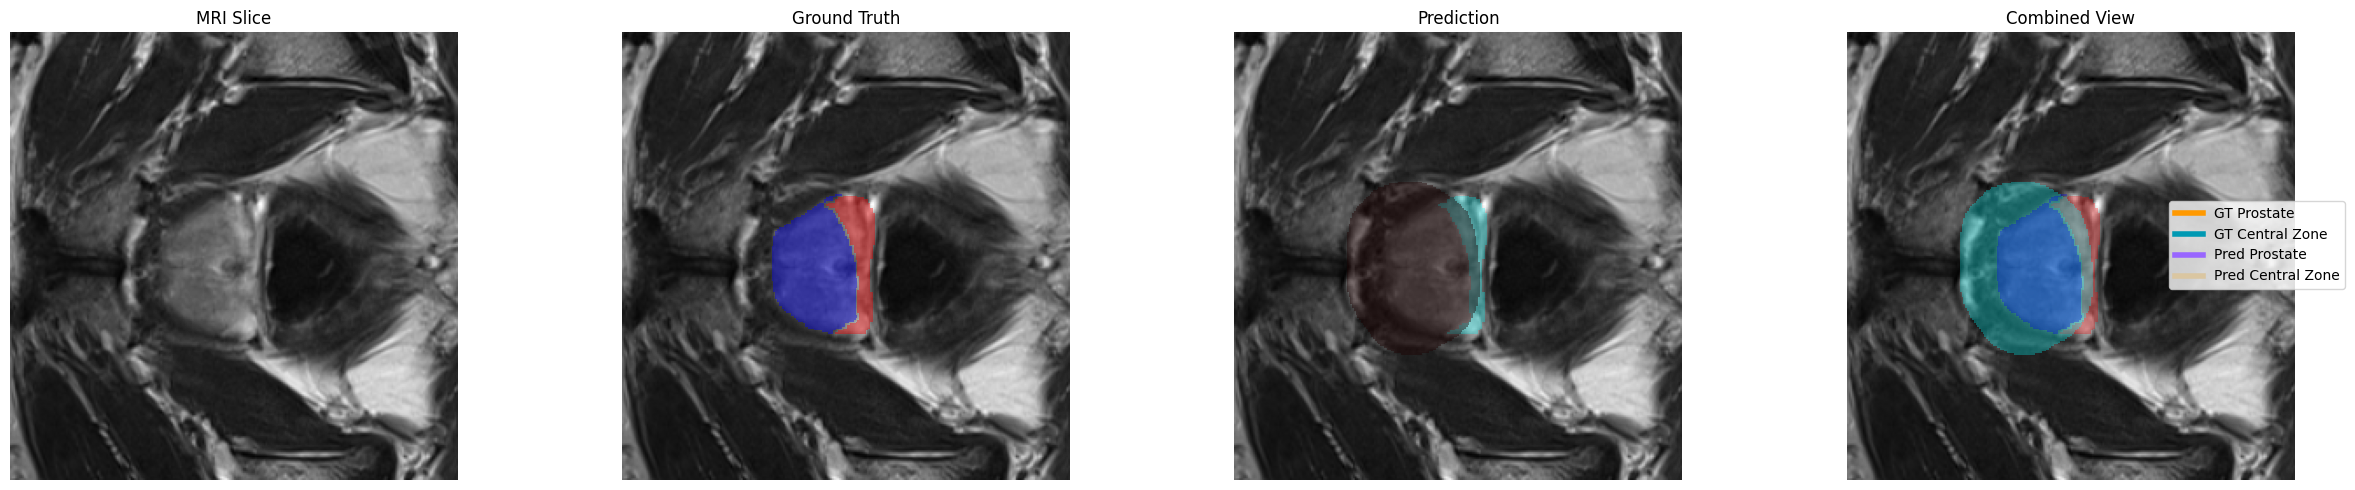

In [187]:
visualizeResults3D(test_dataset,4,17,"test")
#this is the score for one validation

/state/partition1/job-55641154/ipykernel_838593/2434513172.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volume = torch.tensor(volume).to(device).unsqueeze(0)


torch.Size([1, 3, 256, 256, 64])
[0. 1. 2.]
(3, 256, 256, 64)
After argmax  (256, 256, 64)


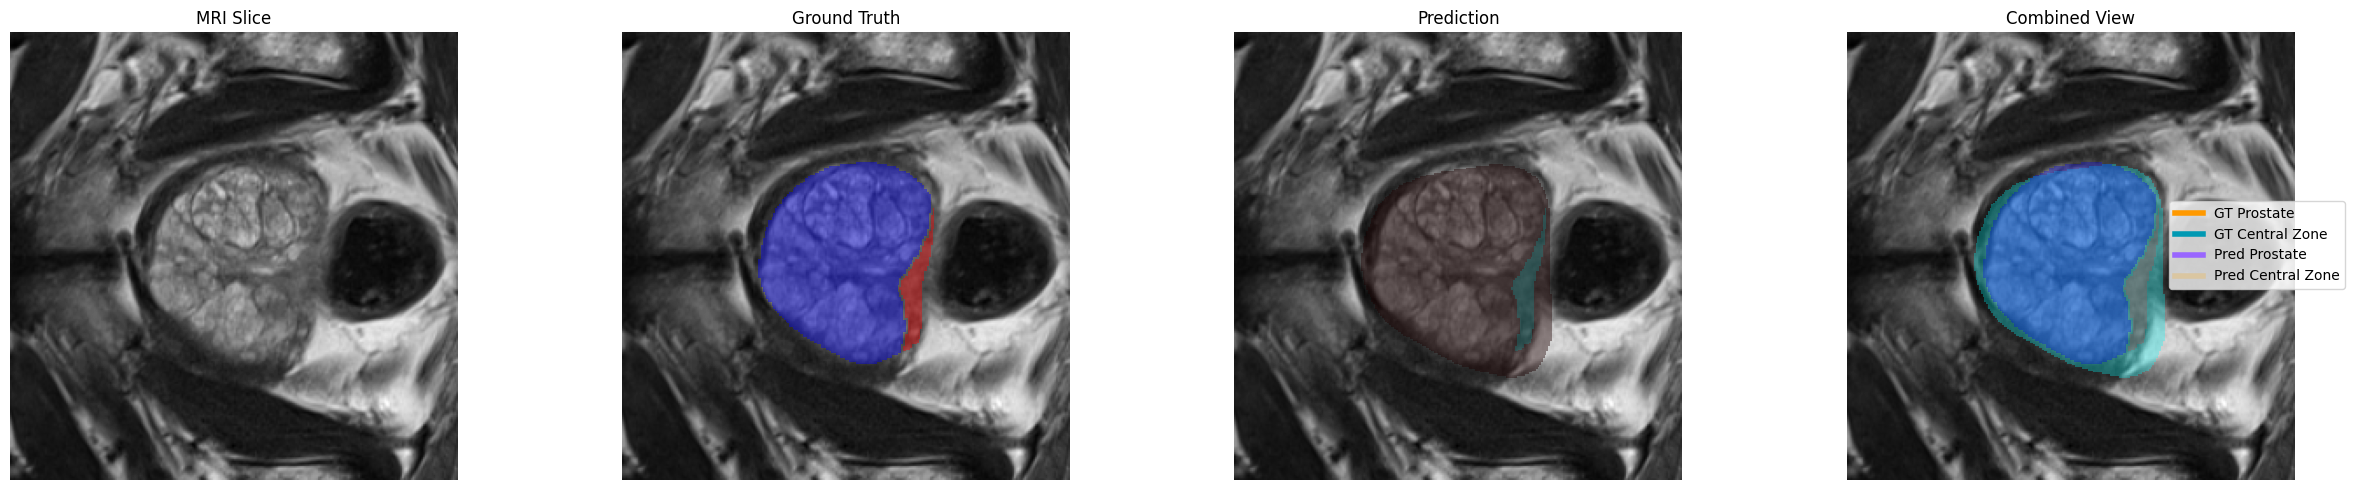

In [188]:
visualizeResults3D(test_dataset,16,17,"test")
#this is the score for one validation

/state/partition1/job-55641154/ipykernel_838593/2434513172.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volume = torch.tensor(volume).to(device).unsqueeze(0)


torch.Size([1, 3, 256, 256, 64])
[0. 1. 2.]
(3, 256, 256, 64)
After argmax  (256, 256, 64)


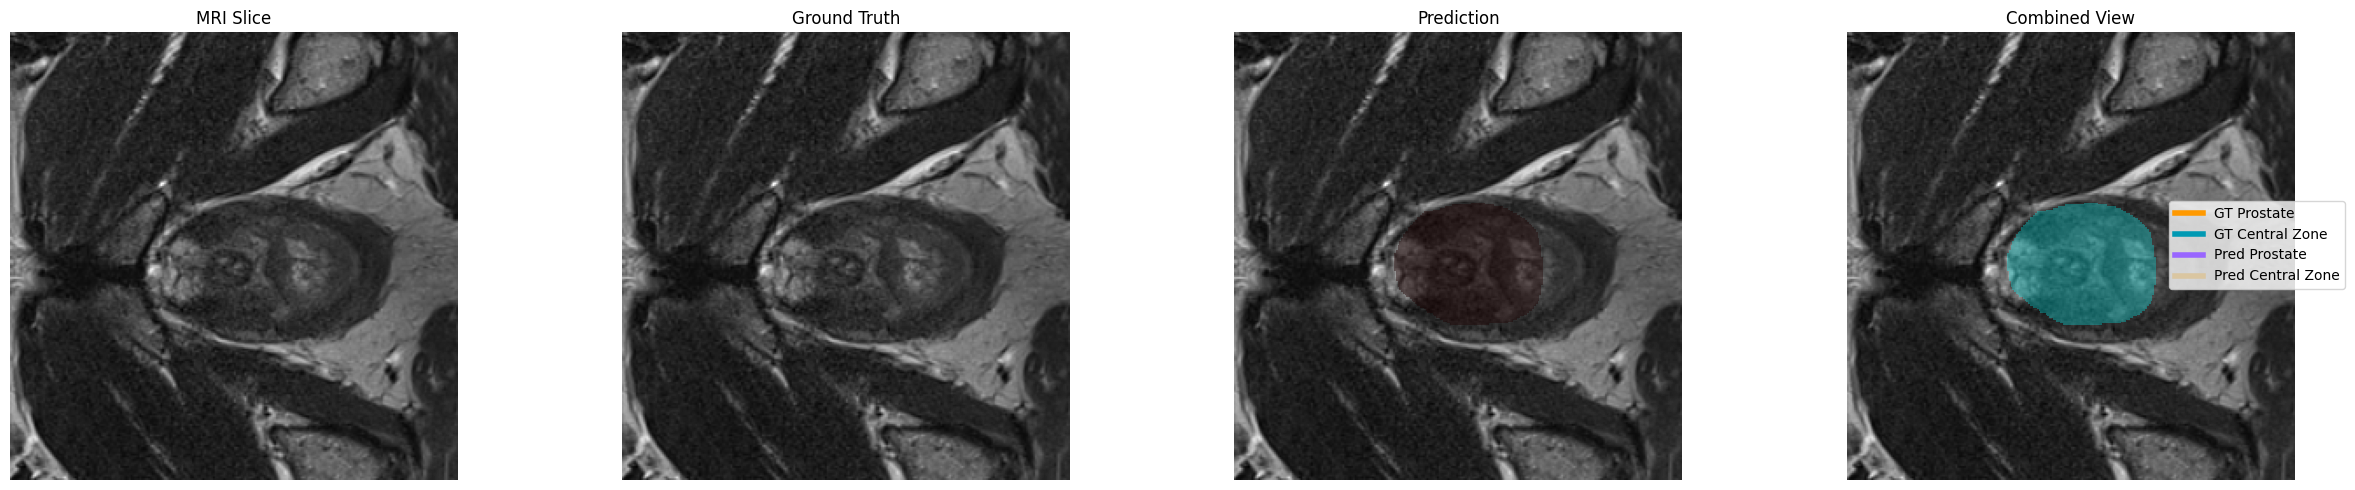

In [189]:
visualizeResults3D(test_dataset,15,7,"test")

In [190]:
visualizeResults(train_dataset,16,"train")

NameError: name 'visualizeResults' is not defined

### visualizeResults(val_dataset,1,"val")


In [ ]:
# Plot the loss curve for every epoch
# Use validation data to figure out optimal number of epochs, because loss increases after certain epoch on valiation set. No need to train data all over again just use saved weights
# Ground truth vs testing data comparision (compare test's segmentation with your own)(overlay them and use different color for each segmentation)
# Discuss the problem, discuss model architecture, discuss the data, plot the curves, and comparision, explain DICE loss coefficient, discuss future work (Vnet, transformers/ autoencoders)
# Compare Unet and Vnet for end sem report
# A separate report of guided studies (should be more comprehensive) (include additional things :comparision between cross entropy loss and dice loss)
# [FUTURE] Look into encoders and decoders for pretraining. Pretrain lots of MRI data to receover image. Then use data from one site to make final layer. THe output of final layer shouldnt be a reconstructed image and instead give segmentation (may have to change more than one layers) of a Unet architecture
# [FUTURE]  Later show that this Unet doesnt give as good of a result as pretrained encoder data. Can also use it for Vnet (look into papers do it)